In [53]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
np.random.seed(42)

import os
for dirname, _, filenames in os.walk("/content/drive/MyDrive/GWU/STAT6289/Portraits"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/GWU/STAT6289/Portraits/c6ac43f129d47e8021e03d8be829d5fdc.jpg
/content/drive/MyDrive/GWU/STAT6289/Portraits/c78c525033872fc48b4e8f5c20d937a1c.jpg
/content/drive/MyDrive/GWU/STAT6289/Portraits/c69b0b9fcd9c3b2e0e2aebfd2be6780ec.jpg
/content/drive/MyDrive/GWU/STAT6289/Portraits/c5e53e5e2385ca6e68b150ed3fbf1d6bc.jpg
/content/drive/MyDrive/GWU/STAT6289/Portraits/c8baf2c0b71fd4f4bc37e50489cdd642c.jpg
/content/drive/MyDrive/GWU/STAT6289/Portraits/c7de037615f73a41c58e6d7c093f4397c.jpg
/content/drive/MyDrive/GWU/STAT6289/Portraits/c7ef8c84f394528690f10d621609b69fc.jpg
/content/drive/MyDrive/GWU/STAT6289/Portraits/c7cbd328622c2a4a3875e41d16212cd4c.jpg
/content/drive/MyDrive/GWU/STAT6289/Portraits/c7b1f2e2a64153c65aac735983f10d65c.jpg
/content/drive/MyDrive/GWU/STAT6289/Portraits/c740818e33bce079d5a92fd54c42b713c.jpg
/content/drive/MyDrive/GWU/STAT6289/Portraits/c85b58c020c89f440acb68784b29e4e3c.jpg
/content/drive/MyDrive/GWU/STAT6289/Portraits/c76f705c8e4c491b3c67832cdda412

In [54]:
#Importing Libraries
import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#EDE9DE","figure.facecolor":"#D8CA7E"})

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
#Importing data
data_path = "/content/drive/MyDrive/GWU/STAT6289/Portraits"
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 4117 files belonging to 1 classes.


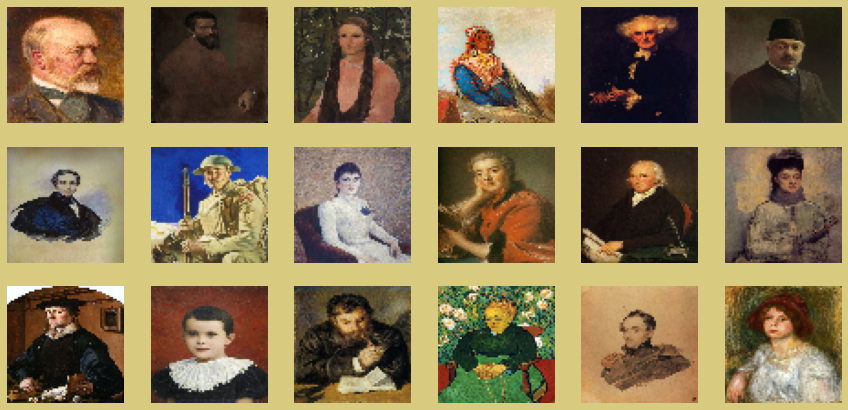

In [56]:
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset            
Show_Img(data)

In [57]:
#Preprocessing the dataset for model
data = data.map(lambda x: x / 255.0)
data

<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [58]:
latent_dim = 100
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4096)              413696    
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_12 (UpSamplin  (None, 8, 8, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization_24 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 8, 8, 256)        

(-0.5, 63.5, 63.5, -0.5)

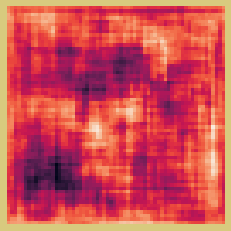

In [59]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training 
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

In [60]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_15 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 17, 17, 64)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_28 (Bat  (None, 17, 17, 64)       256       
 chNormalization)                                     

In [61]:
#for the random image generated
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.5001217]], shape=(1, 1), dtype=float32)


In [62]:
#Code Sourced from keras sample. find the link in the Resorces below

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [63]:
#Defining the number of epochs
epochs = 100
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

Epoch 1/100
65/65 [==============================] - 28s 349ms/step - d_loss: 0.6634 - g_loss: 0.7457
Epoch 2/100
65/65 [==============================] - 26s 353ms/step - d_loss: 0.6907 - g_loss: 0.7363
Epoch 3/100
65/65 [==============================] - 26s 351ms/step - d_loss: 0.6773 - g_loss: 0.7700
Epoch 4/100
65/65 [==============================] - 26s 348ms/step - d_loss: 0.6518 - g_loss: 0.8388
Epoch 5/100
65/65 [==============================] - 26s 354ms/step - d_loss: 0.6726 - g_loss: 0.8093
Epoch 6/100
65/65 [==============================] - 26s 355ms/step - d_loss: 0.6690 - g_loss: 0.8060
Epoch 7/100
65/65 [==============================] - 26s 347ms/step - d_loss: 0.6421 - g_loss: 0.8565
Epoch 8/100
65/65 [==============================] - 26s 351ms/step - d_loss: 0.6107 - g_loss: 0.9355
Epoch 9/100
65/65 [==============================] - 26s 352ms/step - d_loss: 0.5608 - g_loss: 1.0265
Epoch 10/100
65/65 [==============================] - 26s 354ms/step - d_loss: 0.5

Text(0.5, 1.0, 'Learning Curve')

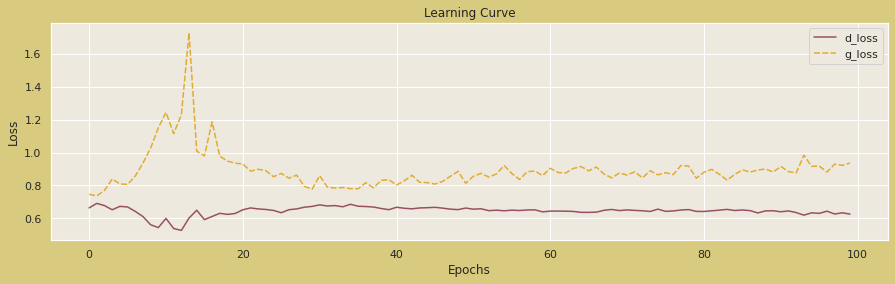

In [64]:
pal=["#994F5F","#E2AB30"]
#Plotting the learning curve
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df, palette= pal)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")

In [65]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("/content/drive/MyDrive/GWU/STAT6289/Ai Portraits/New Portraits{:02d}.png".format(i)) 
    return 
Images = Potrait_Generator()

Found 18 files belonging to 1 classes.


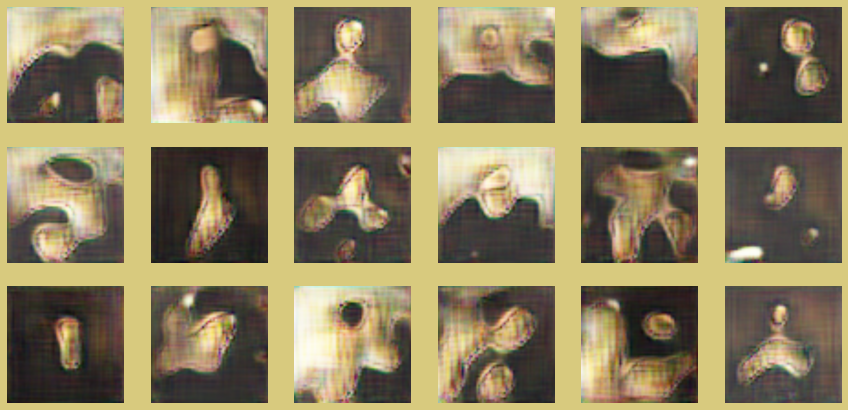

In [67]:
#Loading generated images
Generated_path = "/content/drive/MyDrive/GWU/STAT6289/Ai Portraits"
Potraits_generated = tf.keras.preprocessing.image_dataset_from_directory(Generated_path, label_mode = None)
#Plotting generated images
Show_Img(Potraits_generated)